<table class="ee-notebook-buttons" align="center">
    <td><a target="_blank"  href="https://colab.research.google.com/github/ytarazona/lomas-pnud/blob/main/notebooks/05%20Media%20mensual%20del%20%C3%ADndice%20NDVI.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

## 1. Importación de las bibliotecas necesarias

In [ ]:
# Instalar geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

In [12]:
import ee
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ee.Initialize()

## 2. Media mensual del índice NDVI

### 2.1 Algoritmo para procesar las medias mensuales

In [4]:
## DESCARGA DE LAS AREAS MENSUALES DE CADA LOMA ENTRE EL PERIODO 2000 A 2020

# Funcion de corte
def clipper(image):
    return image.clip(region)

# Definimos la region de estudio
region = ee.FeatureCollection('users/geoyons/tugee/LimaProv')

# Funcion de filtro de pixeles contaminados usando la banda de fiabilidad
def maskSQA(image):
    mask = image.select('SummaryQA').eq(0).Or(image.select('SummaryQA').eq(1))
    imageMask = image.updateMask(mask)
    return imageMask

modis = ee.ImageCollection('MODIS/006/MOD13Q1')\
          .filter(ee.Filter.date('2000-01-01', '2020-12-31'))\
          .map(clipper)\
          .map(maskSQA)

months = ee.List.sequence(1,12)

# El resultado es una ImageCollection con una imagen para cada mes
def MonthYear(m):
    return modis.filter(ee.Filter.calendarRange(m, m, 'month'))\
                          .filterBounds(region)\
                          .select('NDVI')\
                          .mean().set('month', m)
    
byMonth = ee.ImageCollection.fromImages(months.map(MonthYear))

# Esto realiza el apilado
def stackCollection(coll):
    first = ee.Image(coll.first()).select([])
    def appendBands(image, previous):
        dateString = ee.Date(image.get('system:time_start')).format('yyyy-MM-dd')
        return ee.Image(previous).addBands(image)
    return ee.Image(coll.iterate(appendBands, first))

# Resultado final
ndvi_2000_2020 = stackCollection(byMonth)

Es posible también descargar el stack de las imágenes medias mensuales del 2000 al 2020 de NDVI MODIS.

In [ ]:
# Descargar directamente a Google Drive
task = ee.batch.Export.image(ndvi_2000_2020, 
                              'NDVI_MESES_MEDIA_2000-2020_PROVLIMA', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()

### 2.2 Algoritmo para graficar las medias mensuales por lomas

In [10]:
path = r'F:\ConsultoriaPNUD\Data\MapLomas\MOD13Q1_NDVI'
os.chdir(path)
os.getcwd()

'F:\\ConsultoriaPNUD\\Data\\MapLomas\\MOD13Q1_NDVI'

In [ ]:
%matplotlib qt
# Leer la tabla de nombres de lomas con PANDAS
data = pd.read_csv("F:/ConsultoriaPNUD/Data/CSV/Lomas_Modis.csv", delimiter = ";")
names = data['Nombre'].tolist() # convertir toda el df => df.values.tolist()

for i in np.arange(0, len(names), 1):
    lms = ee.FeatureCollection('users/geoyons/tugee/Lomas_Modis')\
            .filterMetadata('Nombre','equals', names[i])
    #mask = ndvi_2000_2020.divide(10000).gte(0.15)
    #ndviMedia = ndvi_2000_2020.divide(10000).updateMask(mask).clip(lms)
    ndviMedia = ndvi_2000_2020.divide(10000).gte(0.15).clip(lms)

    md = ndviMedia.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': lms.geometry(),
        'scale': 250,
        'maxPixels': 1e13})
    
    medias = md.getInfo()
    medias = [medias['NDVI'], medias['NDVI_1'],medias['NDVI_2'],medias['NDVI_3'],medias['NDVI_4'],medias['NDVI_5'],
             medias['NDVI_6'],medias['NDVI_7'],medias['NDVI_8'],medias['NDVI_9'],medias['NDVI_10'],medias['NDVI_11']]
    
    # Ploteamos las precisiones globales obtenidas
    x = [1,2,3,4,5,6,7,8,9,10,11,12]
    labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dec']

    fig, axes = plt.subplots(figsize=(8,5))
    axes.plot(x, medias, marker = 'o', ms = 8, color="b", label="Valor NDVI")
    axes.set_xticks(x) 
    axes.set_xticklabels(labels, fontsize=12)
    axes.set_ylabel("Valores de NDVI")
    axes.set_xlabel("Meses")
    axes.set_ylim(bottom=min(medias)-0.025, top=max(medias)+0.05)
    axes.set_title("Promedios mensuales: "+names[i])
    axes.grid(True)
    axes.legend(loc="upper right", fontsize=15)
    plt.show()
    plt.savefig('Grafico_'+names[i]+'_MediaNDVI'+'.png')

### 2.3 Algoritmo para graficar las medias mensuales de las lomas en un solo grafico

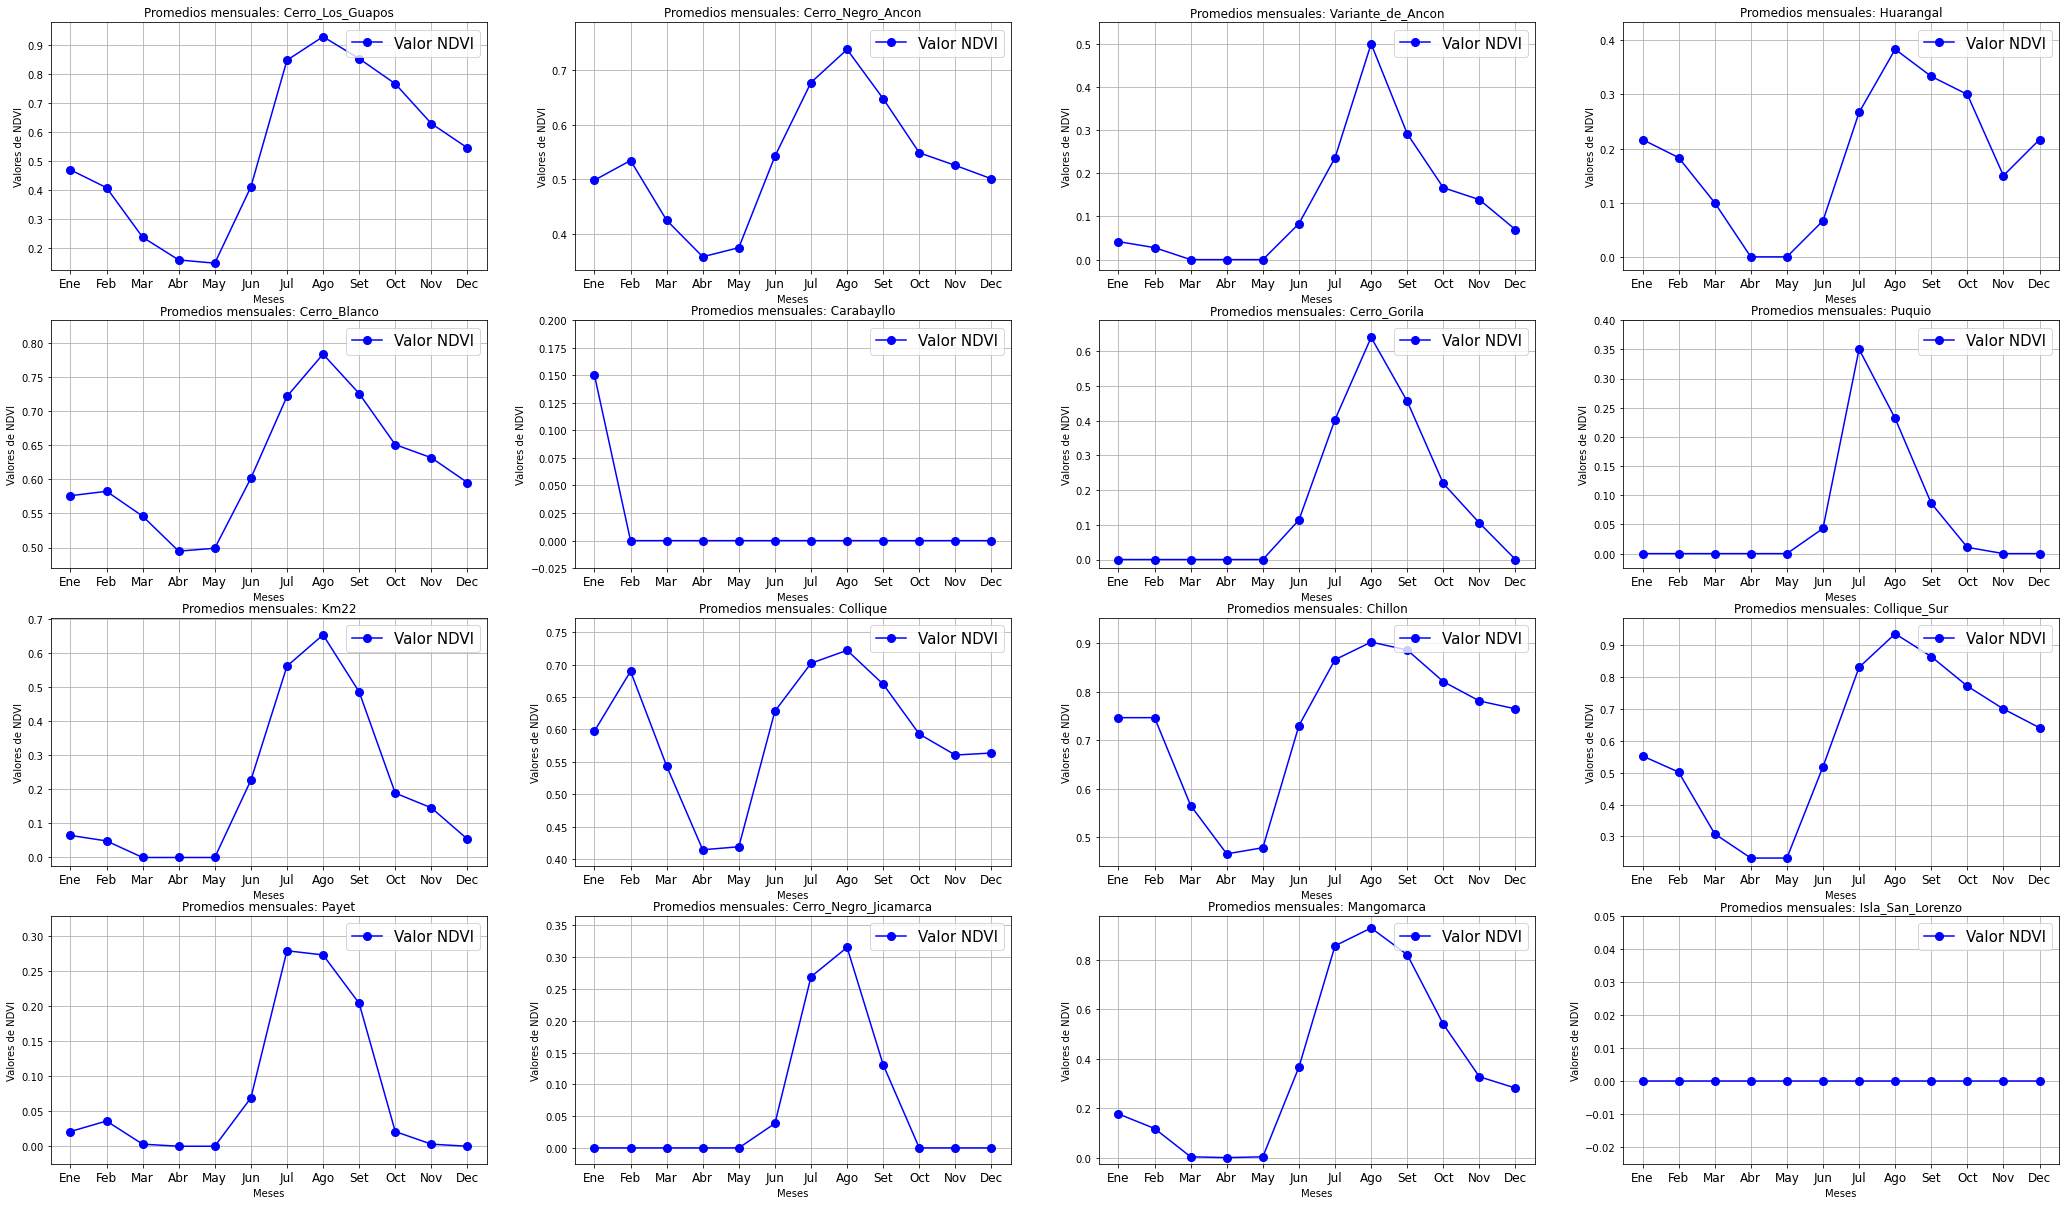

In [19]:
%matplotlib inline
# Leer la tabla de nombres de lomas con PANDAS
data = pd.read_csv("F:/ConsultoriaPNUD/Data/CSV/Lomas_Modis.csv", delimiter = ";")
names = data['Nombre'].tolist() # convertir toda el df => df.values.tolist()

fig = plt.figure(figsize=(36,21))

for i in np.arange(0, 20, 1):# part1: 0,20; part2: 20, 36
    lms = ee.FeatureCollection('users/geoyons/tugee/Lomas_Modis')\
            .filterMetadata('Nombre','equals', names[i])
    #mask = ndvi_2000_2020.divide(10000).gte(0.15)
    #ndviMedia = ndvi_2000_2020.divide(10000).updateMask(mask).clip(lms)
    ndviMedia = ndvi_2000_2020.divide(10000).gte(0.15).clip(lms)

    md = ndviMedia.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': lms.geometry(),
        'scale': 250,
        'maxPixels': 1e13})
    
    medias = md.getInfo()
    medias = [medias['NDVI'], medias['NDVI_1'],medias['NDVI_2'],medias['NDVI_3'],medias['NDVI_4'],medias['NDVI_5'],
             medias['NDVI_6'],medias['NDVI_7'],medias['NDVI_8'],medias['NDVI_9'],medias['NDVI_10'],medias['NDVI_11']]
    
    # Ploteamos las precisiones globales obtenidas
    x = [1,2,3,4,5,6,7,8,9,10,11,12]
    labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Set', 'Oct', 'Nov', 'Dec']

    #i = i-20
    axes = fig.add_subplot(4,5,i+1) # 4,4
    axes.plot(x, medias, marker = 'o', ms = 8, color="b", label="Valor NDVI")
    axes.set_xticks(x) 
    axes.set_xticklabels(labels, fontsize=12)
    axes.set_ylabel("Valores de NDVI")
    axes.set_xlabel("Meses")
    axes.set_ylim(bottom=min(medias)-0.025, top=max(medias)+0.05)
    axes.set_title("Promedios mensuales: "+names[i])
    axes.grid(True)
    axes.legend(loc="upper right", fontsize=15)
plt.savefig('Media_NDVI_por_loma_UnoSolo_Part2.png')